In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp
import datetime

from sys import platform

if platform == "darwin":
    folder="/Users/sjha/Documents/Github/new_model_data/"  ## mac
if platform == "win32":
    folder="C:\\Users\\jhash\\Documents\\renders\\opto\\" ## windows

print(folder)


C:\Users\jhash\Documents\renders\opto\


In [2]:
g_y=1.24e6   ##Hz
omega_0=4.45e15 ##Hz
del_omega=1e8
omega_1=omega_0-del_omega ##Hz
ohm=1e6         ##Hz
g_z0=0
g_z1=(20*ohm)**0.5
delta_0=100*ohm
N0=1e1

g_y/=ohm
g_z1/=ohm
g_z0/=ohm
omega_1/=ohm
omega_0/=ohm
del_omega/=ohm

# label_list=["$Q$","$P$","$1-n_0$","$n_1$","$n_{-1}$","$\sigma_-$","E_mech"]


In [6]:
def full_ODE(t,z,g_z0,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,a_0,a_p1,a_m1,a_0_d,a_p1_d,a_m1_d=z
    n_0=a_0_d*a_0
    sigma_m=1j*(a_0_d*(a_p1-a_m1)-a_0*(a_p1_d-a_m1_d))
    N_eff=g_z1*(a_p1*a_p1_d+a_m1*a_m1_d)+g_z0*n_0
    q_y_dot     =p_y
    p_y_dot     =-q_y-g_y*sigma_m*N0
    
    q_z_dot     =p_z
    p_z_dot     =-q_z-2*N_eff*N0

    a_0_dot=-1j*(del_omega+g_z0*q_z)*a_0+g_y*q_y*(a_p1-a_m1)/2
    a_p1_dot=-1j*g_z1*q_z*a_p1-g_y*q_y*a_0/2
    a_m1_dot=-1j*g_z1*q_z*a_m1+g_y*q_y*a_0/2
    
    a_0_d_dot=1j*(del_omega+g_z0*q_z)*a_0_d+g_y*q_y*(a_p1_d-a_m1_d)/2
    a_p1_d_dot=1j*g_z1*q_z*a_p1_d-g_y*q_y*a_0_d/2
    a_m1_d_dot=1j*g_z1*q_z*a_m1_d+g_y*q_y*a_0_d/2
    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,a_0_dot,a_p1_dot,a_m1_dot,a_0_d_dot,a_p1_d_dot,a_m1_d_dot]
    return x_list


    
def full_evolve(x_0,a,tf,param_list,N_step=300,method="DOP853"):
    q_z_0,p_z_0,q_y_0,p_y_0=x_0
    g_z0,g_z1,g_y, del_omega, N0=param_list
    z0=np.array([q_z_0,p_z_0,q_y_0,p_y_0,a[0],a[1],a[-1],a[0].conj(),a[1].conj(),a[-1].conj()])
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(full_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-10, atol = 1e-10, t_eval=t,method=method)
    zz=xx.y
    sol=[]
    sol.extend( (np.real(zz[0]),np.real(zz[1]),np.real(zz[2]),np.real(zz[3])) )
    n_0=zz[4]*zz[7]
    n_p1=zz[5]*zz[8]
    n_m1=zz[6]*zz[9]
    N=n_0+n_p1+n_m1
    sigma_m=1j*(zz[7]*(zz[5]-zz[6])-zz[4]*(zz[8]-zz[9]))
    sol.extend( (1-np.real(n_0),np.real(n_p1),np.real(N),np.real(sigma_m)) )
    return sol,t

def Pc(param_list):
    g_z0,g_z1,g_y,del_omega,N0=param_list
    delta=del_omega-2*N0*g_z1*(g_z0-g_z1)+g_z0**2-g_z1**2
    #Pc=g_y**2*N_0/delta
    Pc=(8*delta*g_y**2*N0)/(1-delta**2)**2
    return Pc


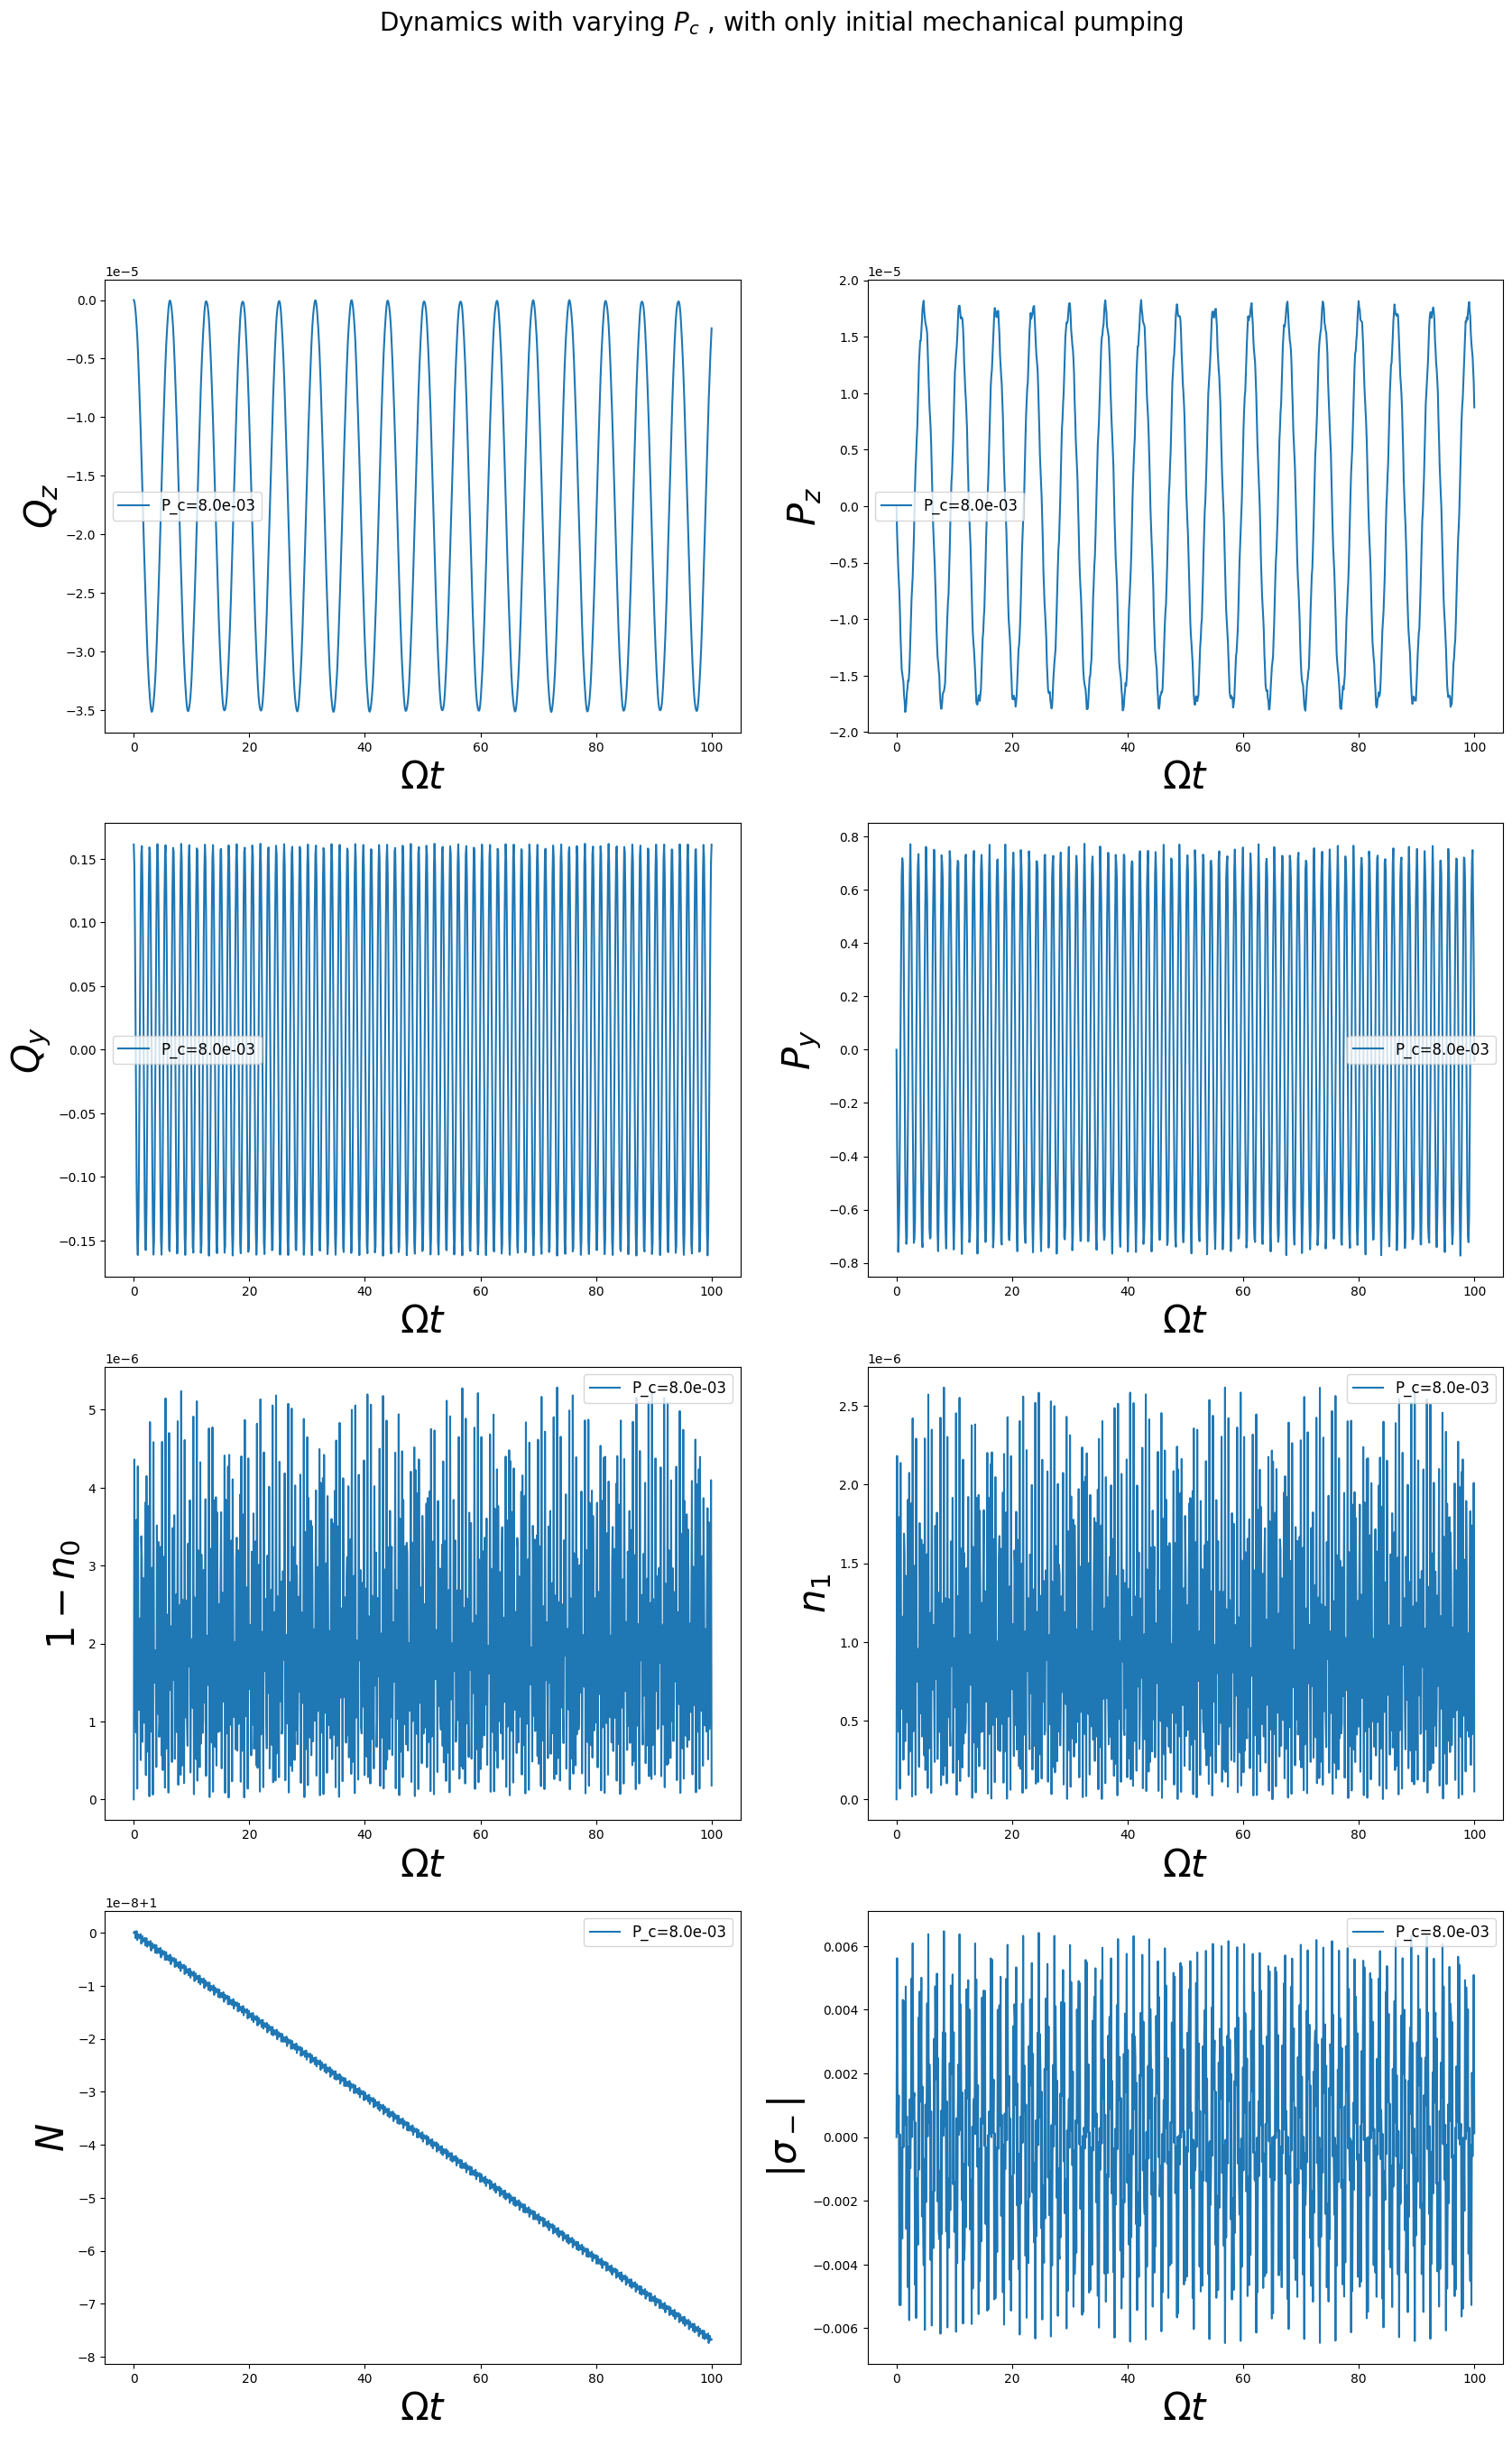

In [7]:
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$1-n_0$","$n_1$","$N$","$|\sigma_-|$"]

tf=1e2
N_step=1000
g_y=1e0
fig, axs = plt.subplots(4, 2,figsize=(20,30))
fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# N0_list=np.linspace(8,9,1)
N0_list=[1000]
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
psi_0=np.array([1+0j,0+0j,0+0j])

for N0 in (N0_list):
    param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=full_evolve(x_0,psi_0,tf,param_list,N_step)
    for i in range(8):
        axs[i//2,i%2].plot(t,zz[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
for i in range(8):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i//2,i%2].legend(fontsize=12)

plt.show() 

In [ ]:
def real_ODE(t,z,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,A0_p,A0_m,A1_p,A1_m,E_opt_0,E_opt_1,E_mech_z,E_mech_y,E_c=z

    sigma_m=2*(A1_p*A0_m-A1_m*(A0_p+1))
    q_y_dot=p_y
    p_y_dot=-q_y-g_y*N0*sigma_m
    
    q_z_dot=p_z
#     p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)
    p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)


    A1_p_dot=-(del_omega-g_z1*q_z)*A1_m-g_y*q_y*(1+A0_p)
    A1_m_dot=+(del_omega-g_z1*q_z)*A1_p-g_y*q_y*A0_m

    A0_p_dot=g_y*q_y*A1_p/2
    A0_m_dot=g_y*q_y*A1_m/2
    
    E_c_dot=2*N0*(A0_p_dot*(A0_p+1)+A0_m_dot*A0_m)*(-g_z1*q_z)+g_y*q_y*N0*(A1_p_dot*A0_m+A1_p*A0_m_dot-A1_m_dot*(A0_p+1)-A1_m*A0_p_dot)-N0*g_z1*(2*A0_p+A0_p**2+A0_m**2)*q_z_dot+g_y*q_y_dot*N0*(A1_p*A0_m-A1_m*(A0_p+1))
    E_mech_dot=(q_y*q_y_dot+p_y*p_y_dot+q_z*q_z_dot+p_z*p_z_dot)/2
    E_mech_z_dot=(q_z*q_z_dot+p_z*p_z_dot)/2
    E_mech_y_dot=(q_y*q_y_dot+p_y*p_y_dot)/2
    E_opt_0_dot=2*N0*(A0_p_dot*(A0_p+1)+A0_m_dot*A0_m)*omega_0
    E_opt_1_dot=N0*(A1_p_dot*A1_p+A1_m_dot*A1_m)*omega_1
    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,A0_p_dot,A0_m_dot,A1_p_dot,A1_m_dot,E_opt_0_dot,E_opt_1_dot,E_mech_z_dot,E_mech_y_dot,E_c_dot]
    return x_list

    
def real_evolve(z0,tf,param_list,N_step=300,method="DOP853"):
    
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(real_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-8, t_eval=t,method=method)
    zz=xx.y
    sol=[]
    for i in range(np.shape(zz)[0]):
        sol.append(np.real(zz[i]))
    return sol,t



In [ ]:
tf=2e1
N_grid=10
# P_c_list=np.linspace(0.01,1,N_grid)
P_c_list=np.array([1.2])

g_y=1e-1
N0_list=(P_c_list*del_omega)**3/(8*g_y**2)
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$E_{opt}^{(0)}$","$E_{opt}^{(1)}$","$E_{mech}_z$","$E_{mech}_y$","$E_{c}$"]
N_step=10000
qy_0=1e-2
for i,P_c in enumerate(P_c_list):
    if (100*(i/(N_grid-1)))%10==0:print((100*(i/(N_grid-1))),"% progressed")
    N0=(P_c*del_omega)**3/(8*g_y**2)
    z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0])
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=eig_evol4(z_0,tf,param_list,N_step)
    file="real_chaotic_P_c={0}_g_y={1}_tf={2}_sep_energy".format(np.round(P_c,4),g_y,tf)
    np.savez_compressed(folder+file, sol=zz, t=t,label=label_list,param=param_list)

time_taken= 1203.858692 seconds


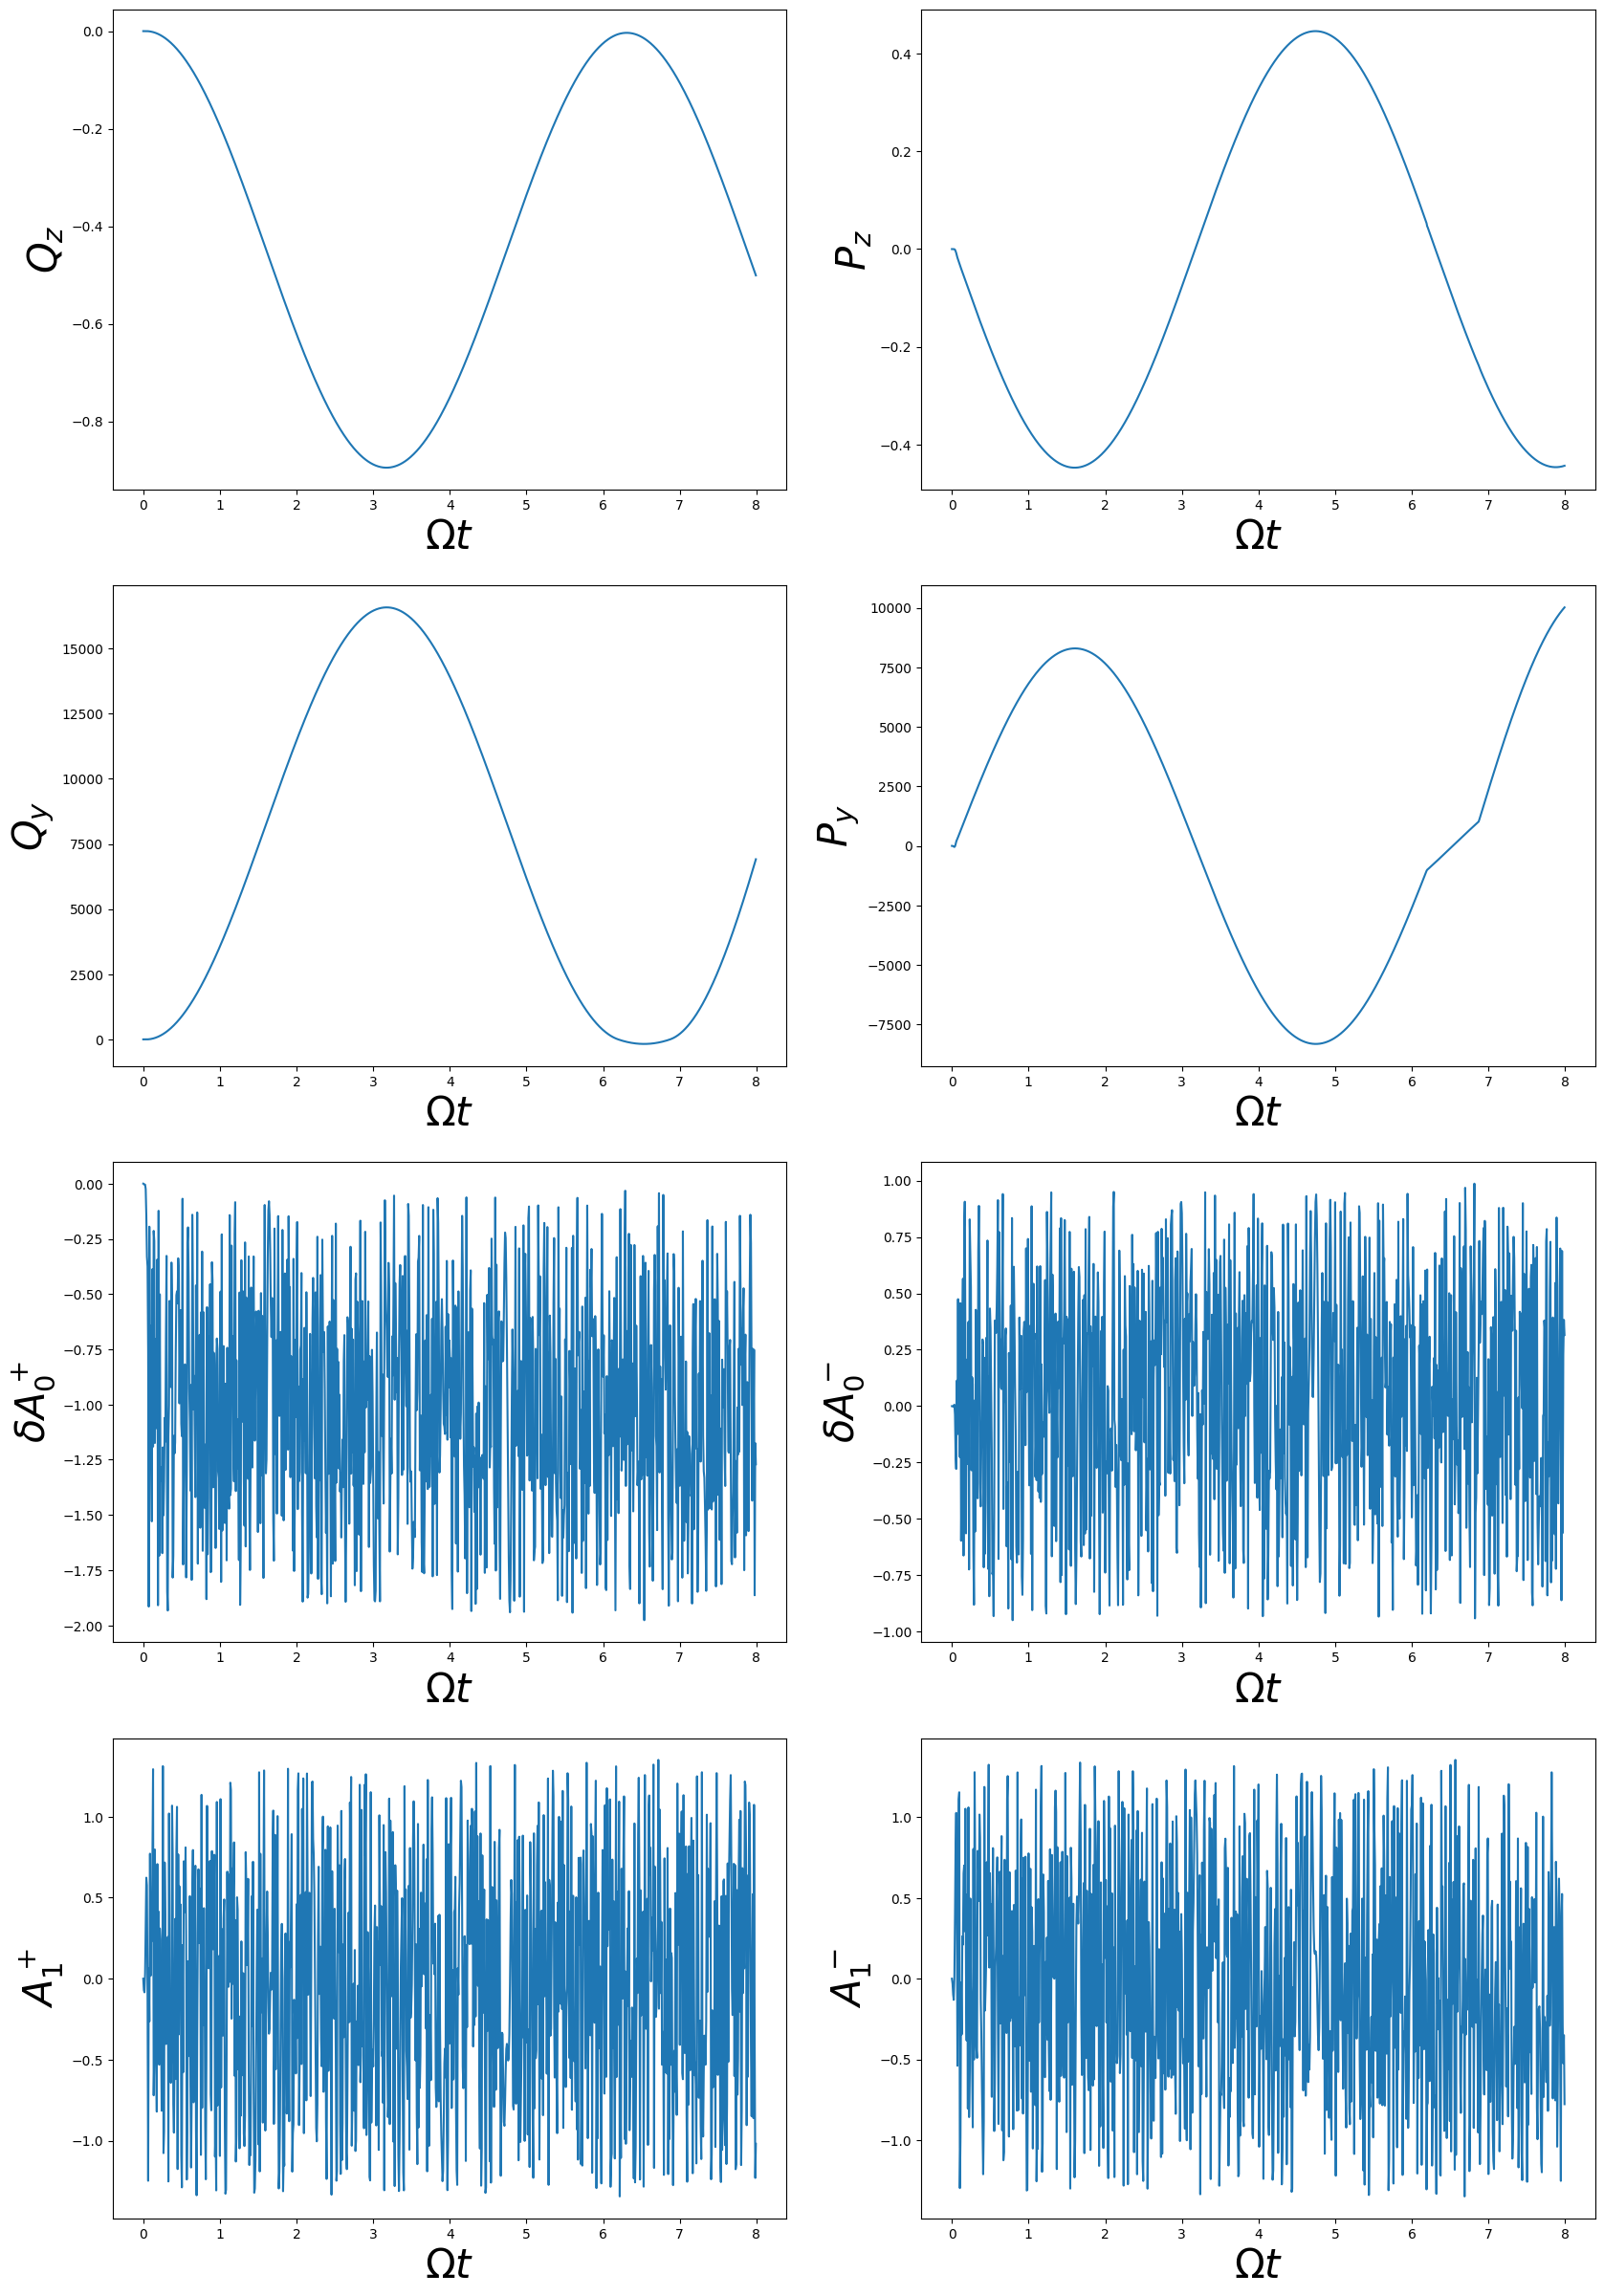

In [10]:
P_c=2 ############### CRITICAL parameter
g_y=1e2
tf=8e0

file="real_chaotic_P_c={0}_g_y={1}_tf={2}".format(P_c,g_y,tf)

data = np.load(folder+file+".npz")
sol=data['sol']
t=data['t']
label_list=data['label']
print("time_taken=",data['time_taken'],"seconds")
fig, axs = plt.subplots(4, 2,figsize=(20,30))

for i in range(8):
    axs[i//2,i%2].plot(t[::10],sol[i][::10])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

In [16]:

    
def psi_evol(z0,tf,param_list,N_step=300,method="DOP853"):
    
    def eig_to_real(zz):
        temp=np.array(zz,dtype=complex)
        N_step=len(zz[0])
        yy=[]
        for i in range(N_step):
            yy.append(U@zz[:4,i])
        temp[:4]=np.array(yy).T
        return temp 
    
    def energy(yy):
        q_y,p_y,A1_p,A1_m,A0_p,A0_m,q_z,p_z=yy[:8]        
        sigma_m=2*(A1_p*A0_m-A1_m*(A0_p+1))
        E=N0*(2*A0_p+A0_p**2+A0_m**2)*(del_omega-g_z1*q_z)
        +(q_y**2+p_y**2+q_z**2+p_z**2)/4+q_y*g_y*N0*sigma_m/2
        return E

    def psi_ODE(t,z,delta,g_y,g_z1,N0):
        tk=(100*t/tf)
#         if tk%10<1e-4:print(np.round(tk,2),"% progressed")
        psi_1,psi_2,psi_3,psi_4,A0_p,A0_m,q_z,p_z,N=z
        psi=np.array([psi_1,psi_2,psi_3,psi_4]).reshape(4,1)
        w=(U@psi)[:,0]
        q_y,p_y,A1_p,A1_m=w
        nl=np.array([0,-2*g_y*N0*(A1_p*A0_m-A1_m*A0_p),+g_z1*q_z*A1_m-g_y*q_y*A0_p,-g_z1*q_z*A1_p-g_y*q_y*A0_m],dtype=complex).reshape(4,1)
        psi_dot=np.diag([-1j*lam,1j*lam,-1j*nu,1j*nu])@psi+U_inv@nl


        q_z_dot=p_z
#         p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)
        p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)

        
        A0_p_dot=g_y*q_y*A1_p/2
        A0_m_dot=g_y*q_y*A1_m/2

        psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot=psi_dot[:,0]
        w_dot=(U@psi_dot)[:,0]
        q_y_dot,p_y_dot,A1_p_dot,A1_m_dot=w_dot
#         N_dot=2*((A0_p+1)*A0_p_dot+A0_m*A0_m_dot)+(A1_p*A1_p_dot+A1_m*A1_m_dot)
        N_dot=2*A0_p_dot+2*A0_p*A0_p_dot+2*A0_m*A0_m_dot+A1_p*A1_p_dot+A1_m*A1_m_dot

        x_list=[psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot,A0_p_dot,A0_m_dot,q_z_dot,p_z_dot,N_dot]
        return x_list

    delta,g_y,g_z1,N0=param_list
    D=((1-delta**2)**2-8*g_y**2*N0*delta)**0.5
    lam=((delta**2+(delta**4-8*g_y**2*N0*delta)**0.5)/2)**0.5
    nu=((delta**2-(delta**4-8*g_y**2*N0*delta)**0.5)/2)**0.5
    delta_0=(8*g_y**2*N0)**(1/3)
    
    lp=(1-delta**2+D)/(2*delta*g_y)
    lm=(1-delta**2-D)/(2*delta*g_y)

    U=np.array([
                [lp,lp,lm,lm],
                [1j*lp*lam,-1j*lp*lam,1j*lm*nu,-1j*lm*nu],
                [1j*lam/delta,-1j*lam/delta,1j*nu/delta,-1j*nu/delta],
                [1,1,1,1]
        ])
    U_inv=np.linalg.inv(U)

    t = np.linspace(0,tf,N_step)
    z0[:4]*=delta*g_y/(2*D)
    xx=solve_ivp(eig_eq3, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-10, atol = 1e-10, t_eval=t,method=method)
    zz=xx.y
    yy=eig_to_real(zz)
    H=energy(yy)
    Num=yy[8]
    sol=[]
    sol.extend( (np.real(yy[0]),np.real(yy[1]),np.real(yy[2]),np.real(yy[3]),np.real(yy[6]),np.real(yy[7]),H,np.real(Num)) )

    return sol,t




0.0 % progressed
80.0 % progressed
100.0 % progressed
100.0 % progressed


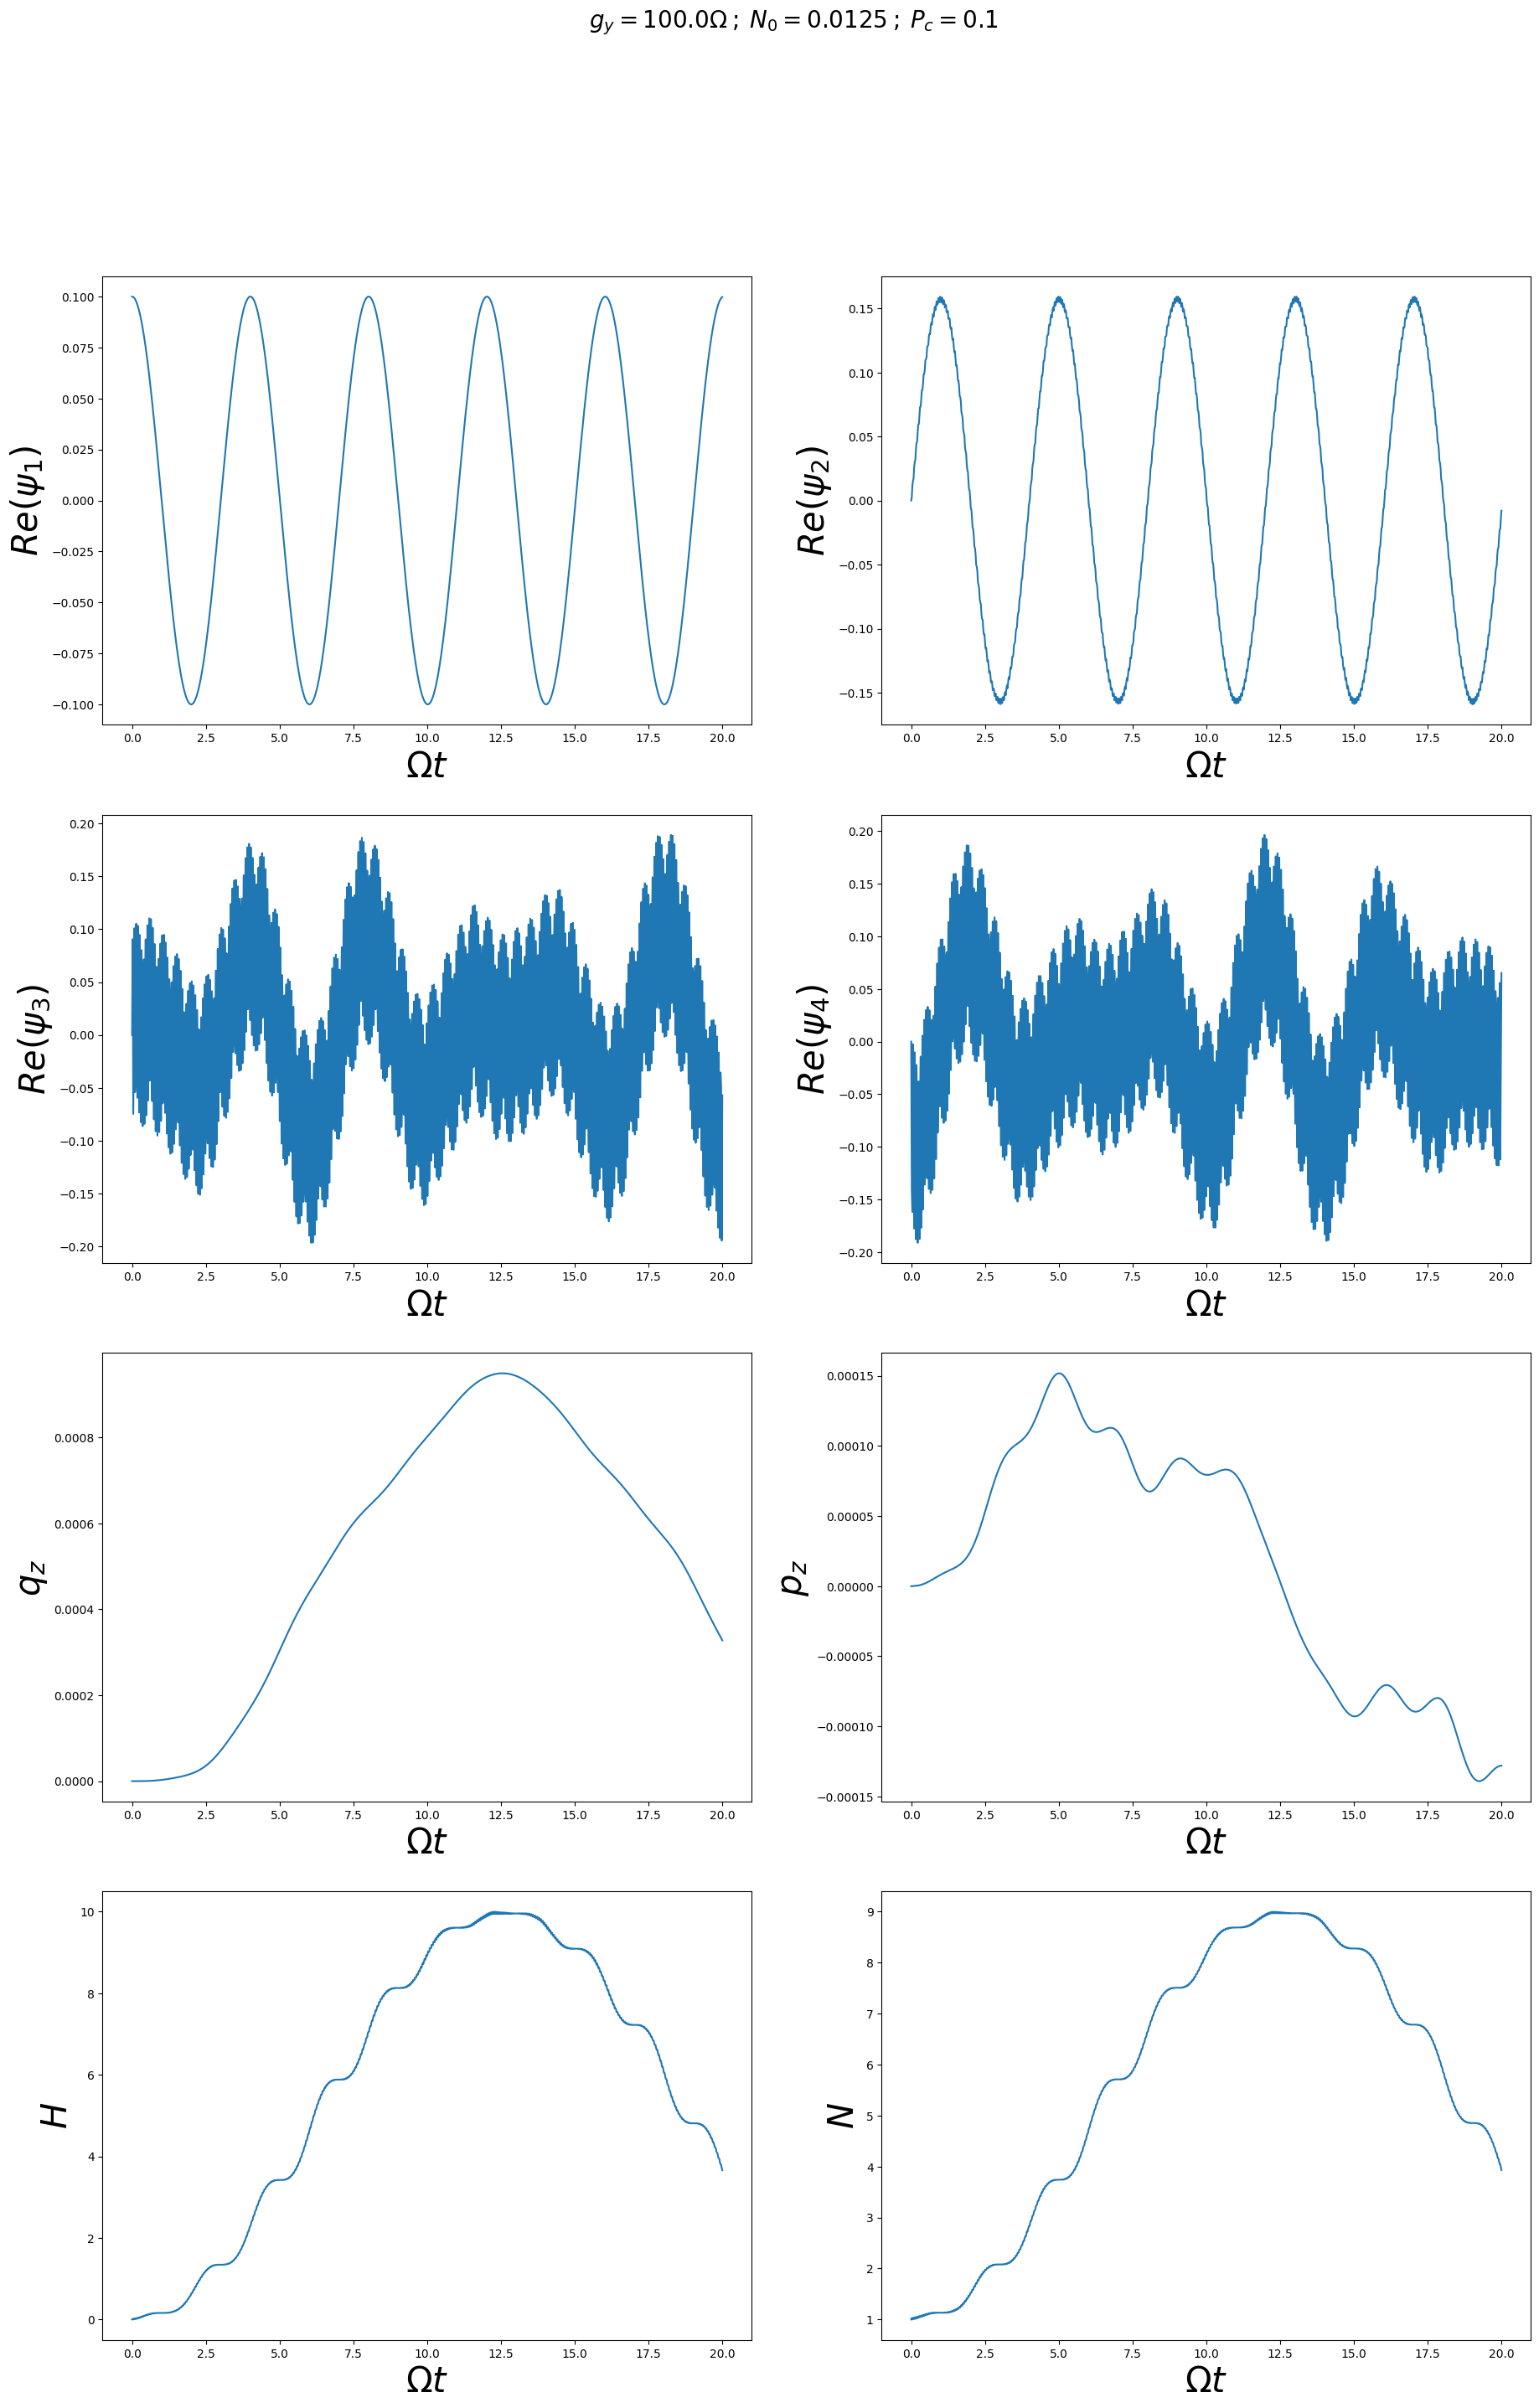

In [14]:
delta=del_omega
P_c=0.1 ############### CRITICAL parameter
g_y=1e2
N0=(P_c*delta)**3/(8*g_y**2)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P_c)

label_list=["$Re(\psi_1)$","$Re(\psi_2)$","$Re(\psi_3)$","$Re(\psi_4)$","$q_z$","$p_z$","$H$","$N$"]
tf=2e1
N_step=1000
# N0=1
q0=1e-1
z0=np.array([1,1,-1,-1,0,0,0,0,0])*q0+0j ## prefactor of delta*g_y/(2*D) multiplied in other function
z0[8]=1


param_list=[del_omega,g_y,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol3(z0,tf,param_list,N_step)

fig, axs = plt.subplots(4, 2,figsize=(22,32))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
fig.suptitle(title, fontsize=20)
for i in range(8):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()